3) Use o modelo acima para calcular os clusters do conjunto de dados sobre o mercado imobiliário da Califórnia.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as tt
import pytensor.tensor as at

In [2]:
df_train = pd.read_csv("sample_data/california_housing_train.csv")
df_test = pd.read_csv("sample_data/california_housing_test.csv")
df = pd.concat([df_train, df_test])
df = df.drop(['housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_house_value'], axis=1)
display(df)

,longitude,latitude,median_income
0,-114.31,34.19,1.4936
1,-114.47,34.40,1.8200
2,-114.56,33.69,1.6509
3,-114.57,33.64,3.1917
4,-114.57,33.57,1.9250
...,...,...,...
2995,-119.86,34.42,1.1790
2996,-118.14,34.06,3.3906
2997,-119.70,36.30,2.2895
2998,-117.12,34.10,3.2708


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaler = scaler.fit_transform(df)

df_scaler = pd.DataFrame(df_scaler, index=df.index, columns=df.columns)

df_scaler


,longitude,latitude,median_income
0,2.623418,-0.672608,-1.251656
1,2.543560,-0.574297,-1.079894
2,2.498640,-0.906681,-1.168880
3,2.493649,-0.930088,-0.358064
4,2.493649,-0.962858,-1.024640
...,...,...,...
2995,-0.146653,-0.564934,-1.417208
2996,0.711819,-0.733467,-0.253397
2997,-0.066795,0.315179,-0.832829
2998,1.220914,-0.714741,-0.316439


In [4]:
coords = {'features': [col for col in df.columns]}
coords

{'features': ['longitude', 'latitude', 'median_income']}

In [5]:
with pm.Model(coords=coords) as model:
    μ0 = pm.Normal("m0", mu=0, sigma=1, dims="features")
    μ1 = pm.Normal("m1", mu=0, sigma=1, dims="features")
    μ2 = pm.Normal("m2", mu=0, sigma=1, dims="features")

    w = pm.Dirichlet("w", a=[1/3, 1/3, 1/3])

    sigma0 = pm.HalfNormal('sigma0', sigma=1, dims="features")
    sigma1 = pm.HalfNormal('sigma1', sigma=1, dims="features")
    sigma2 = pm.HalfNormal('sigma2', sigma=1, dims="features")

    cov_sigma0 = at.diag(sigma0)
    cov_sigma1 = at.diag(sigma1)
    cov_sigma2 = at.diag(sigma2)

    components = [
        pm.MvNormal.dist(μ0, cov_sigma0),
        pm.MvNormal.dist(μ1, cov_sigma1),
        pm.MvNormal.dist(μ2, cov_sigma2)
    ]

    g = pm.Mixture("g", w, components, observed=df_scaler.values)


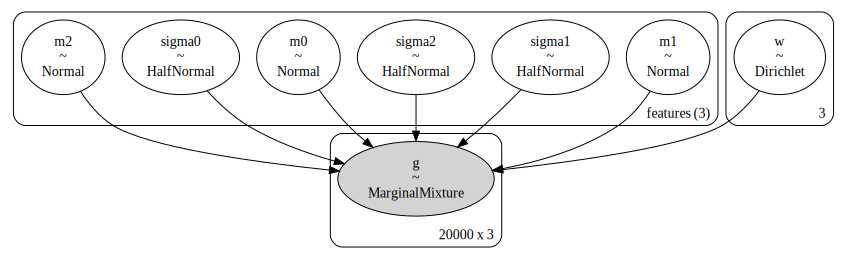

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
  trace = pm.sample()


Output()

In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m0[longitude],0.824,0.003,0.819,0.831,0.0,0.000,4883.0,1413.0,1.0
m0[latitude],-0.837,0.002,-0.842,-0.833,0.0,0.000,4455.0,1310.0,1.0
m0[median_income],0.062,0.010,0.043,0.079,0.0,0.000,5419.0,1532.0,1.0
m1[longitude],-1.299,0.002,-1.302,-1.295,0.0,0.000,3725.0,1597.0,1.0
m1[latitude],0.959,0.003,0.955,0.964,0.0,0.000,4371.0,1550.0,1.0
m1[median_income],0.468,0.019,0.432,0.504,0.0,0.001,5413.0,1527.0,1.0
m2[longitude],-0.777,0.009,-0.795,-0.760,0.0,0.000,3885.0,1365.0,1.0
m2[latitude],1.032,0.010,1.014,1.052,0.0,0.000,4686.0,1216.0,1.0
m2[median_income],-0.442,0.009,-0.458,-0.424,0.0,0.000,4379.0,1526.0,1.0
sigma0[longitude],0.105,0.002,0.102,0.108,0.0,0.000,4388.0,1324.0,1.0


In [9]:
with model:
  trace_post = pm.sample_posterior_predictive(trace)

Output()

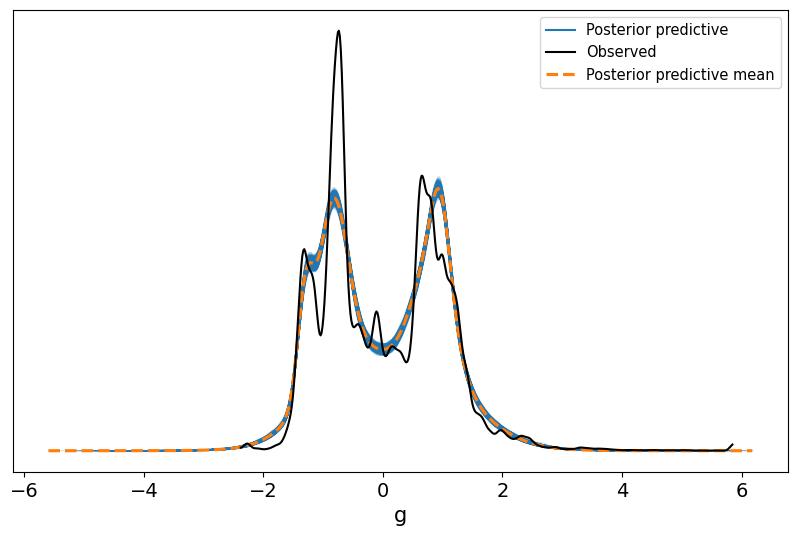

In [21]:
az.plot_ppc(trace_post, mean=True, figsize=(10, 6), textsize=14)

plt.show()


In [19]:
g_samples = trace_post.posterior_predictive["g"]

mean_predictions = g_samples.mean(dim=('chain', 'draw')).values

clusters = np.argmax(mean_predictions, axis=1)

df["Cluster"] = clusters
display(df)
Num_clusters = df['Cluster'].nunique()
print(f"\nNúmero de clusters: {Num_clusters}")
df.to_csv("df_california_housing_clusters.csv", index=False)


,longitude,latitude,median_income,Cluster
0,-114.31,34.19,1.4936,0
1,-114.47,34.40,1.8200,0
2,-114.56,33.69,1.6509,2
3,-114.57,33.64,3.1917,1
4,-114.57,33.57,1.9250,2
...,...,...,...,...
2995,-119.86,34.42,1.1790,2
2996,-118.14,34.06,3.3906,1
2997,-119.70,36.30,2.2895,1
2998,-117.12,34.10,3.2708,1



Número de clusters: 3
